In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
import time
from sklearn.metrics import explained_variance_score

In [2]:
class AP_GRU_Single(nn.Module):
    def __init__(self, H_no, device):
        super().__init__()
        
        self.H_no = H_no
        self.device = device
        
        self.rnn = nn.GRU(1, H_no, batch_first=True)
        self.linear = nn.Linear(H_no, 1)
        
    def forward(self, V):
        #V is shape (batch, 50000)

        rnn_out, _ = self.rnn(V.unsqueeze(2)) #(batch,50000,H)
        rnn_out = rnn_out.reshape(-1,self.H_no)
        lin_out = self.linear(rnn_out) #(batch*50000,1)
        lin_out = lin_out.reshape(V.shape[0], V.shape[1])
        
        return lin_out



In [5]:
batch_size = 20
batch_length = 50000
H_no = 30
device = torch.device("cuda")

epoch_no = 300
iter_no = epoch_no * 980 // batch_size

#V = np.load("/media/hdd01/sklee/CA1_clust4-60/data/vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy").reshape(-1,50001)[:,:50000]
V = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/na_pred_nona_true/V_na_pred_nona_true.npy")
S = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/data/V_diff_stimseed1.npy").reshape(-1,batch_length)

V -= np.mean(V)

V = torch.from_numpy(V)
S = torch.from_numpy(S)


In [6]:
V_train = V[:980].float()
V_test = V[980:].float().to(device)
S_train = S[:980].float()
S_test = S[980:].float() .to(device)

train_idx = np.empty((epoch_no, 980//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0,980,batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)


In [7]:
model = AP_GRU_Single(H_no, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

bce_criterion = nn.BCELoss(reduction="mean")

3001


In [8]:
score_list = []

part_time_idx = torch.arange(0,50000)

for i in tnrange(iter_no):
    s = time.time()
    model.train()
    optimizer.zero_grad()
    
    batch_idx_start = train_idx[i]
    batch_idx = torch.arange(batch_idx_start, batch_idx_start+5).long()
    batch_S = S_train[batch_idx].to(device)[:,part_time_idx]
    batch_V = V_train[batch_idx].to(device)[:,part_time_idx]
    
    S_out = model(batch_V)
    loss = torch.mean((S_out - batch_S)**2)
    #loss = torch.var(S_out - batch_S)
    
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 20)
    optimizer.step()
    
    step_time = time.time() - s
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        test_S_out = model(V_test[:,part_time_idx])
        test_loss = explained_variance_score(S_test[:,part_time_idx].cpu().detach().numpy().flatten(), test_S_out.cpu().detach().numpy().flatten())
        train_loss = explained_variance_score(batch_S.cpu().detach().numpy().flatten(), S_out.cpu().detach().numpy().flatten())
        
        score_list.append(test_loss)
        print(i, test_loss, train_loss)

<ipython-input-8-d90916cc9010>:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


  0%|          | 0/14700 [00:00<?, ?it/s]

0 0.003847777843475342 0.0031536221504211426
49 0.015435278415679932 0.015293598175048828
99 0.02918720245361328 0.031427204608917236
149 0.03408944606781006 0.040656328201293945
199 0.03989553451538086 0.04797846078872681
249 0.05550646781921387 0.05143481492996216
299 0.0637887716293335 0.06661790609359741
349 0.08927655220031738 0.10292315483093262
399 0.12103402614593506 0.11878401041030884
449 0.13627570867538452 0.1303243637084961
499 0.16518068313598633 0.1735318899154663
549 0.18448126316070557 0.19336199760437012
599 0.1554691195487976 0.15373331308364868
649 0.16729825735092163 0.1404261589050293
699 0.1803719401359558 0.14210987091064453
749 0.19705408811569214 0.18907976150512695
799 0.21773695945739746 0.22315722703933716
849 0.23630398511886597 0.2476525902748108
899 0.2485184669494629 0.19949233531951904
949 0.21652907133102417 0.21534979343414307
999 0.2583879232406616 0.2134912610054016
1049 0.2241716980934143 0.22210168838500977
1099 0.23963826894760132 0.217821061611

9399 0.3863183259963989 0.3941214680671692
9449 0.3728918433189392 0.3187592625617981
9499 0.3860201835632324 0.4088146686553955
9549 0.36990976333618164 0.35283178091049194
9599 0.3808053731918335 0.4255778193473816
9649 0.38125288486480713 0.4204801917076111
9699 0.37649261951446533 0.4193965196609497
9749 0.3848647475242615 0.3588576316833496
9799 0.3725687265396118 0.3948233723640442
9849 0.37999510765075684 0.34280937910079956
9899 0.3754096031188965 0.36320459842681885
9949 0.37679654359817505 0.33625328540802
9999 0.36289089918136597 0.3978516459465027
10049 0.358553409576416 0.3651038408279419
10099 0.3870607018470764 0.4149430990219116
10149 0.38743287324905396 0.4778916835784912
10199 0.37437283992767334 0.3997170329093933
10249 0.3726249933242798 0.3522823452949524
10299 0.3789633512496948 0.34255701303482056
10349 0.34484148025512695 0.3258638381958008
10399 0.3539698123931885 0.2997499704360962
10449 0.37117844820022583 0.40632349252700806
10499 0.3824794292449951 0.355538

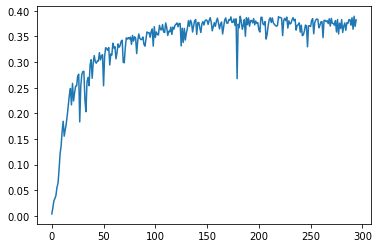

In [9]:
plt.plot(np.asarray(score_list))

(23000.0, 26000.0)

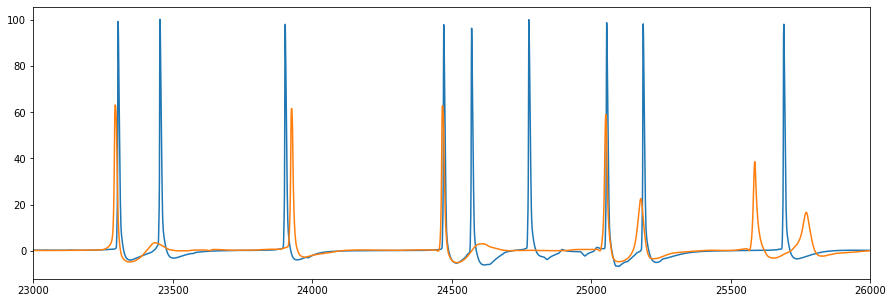

In [10]:
plt.figure(figsize = (15,5))
plt.plot(S_test[0].cpu().detach().numpy()[part_time_idx])
plt.plot(test_S_out[1].cpu().detach().numpy())
plt.xlim(23000,26000)
#plt.ylim(-1,10)

In [11]:
#torch.save(model.state_dict(), "/media/hdd01/sklee/CA1_clust4-60_AP/na_pred_nona_true/gru_h30.pt")
#np.save("/media/hdd01/sklee/CA1_clust4-60_AP/na_pred_nona_true/gru_h30_test.npy", test_S_out.cpu().detach().numpy())